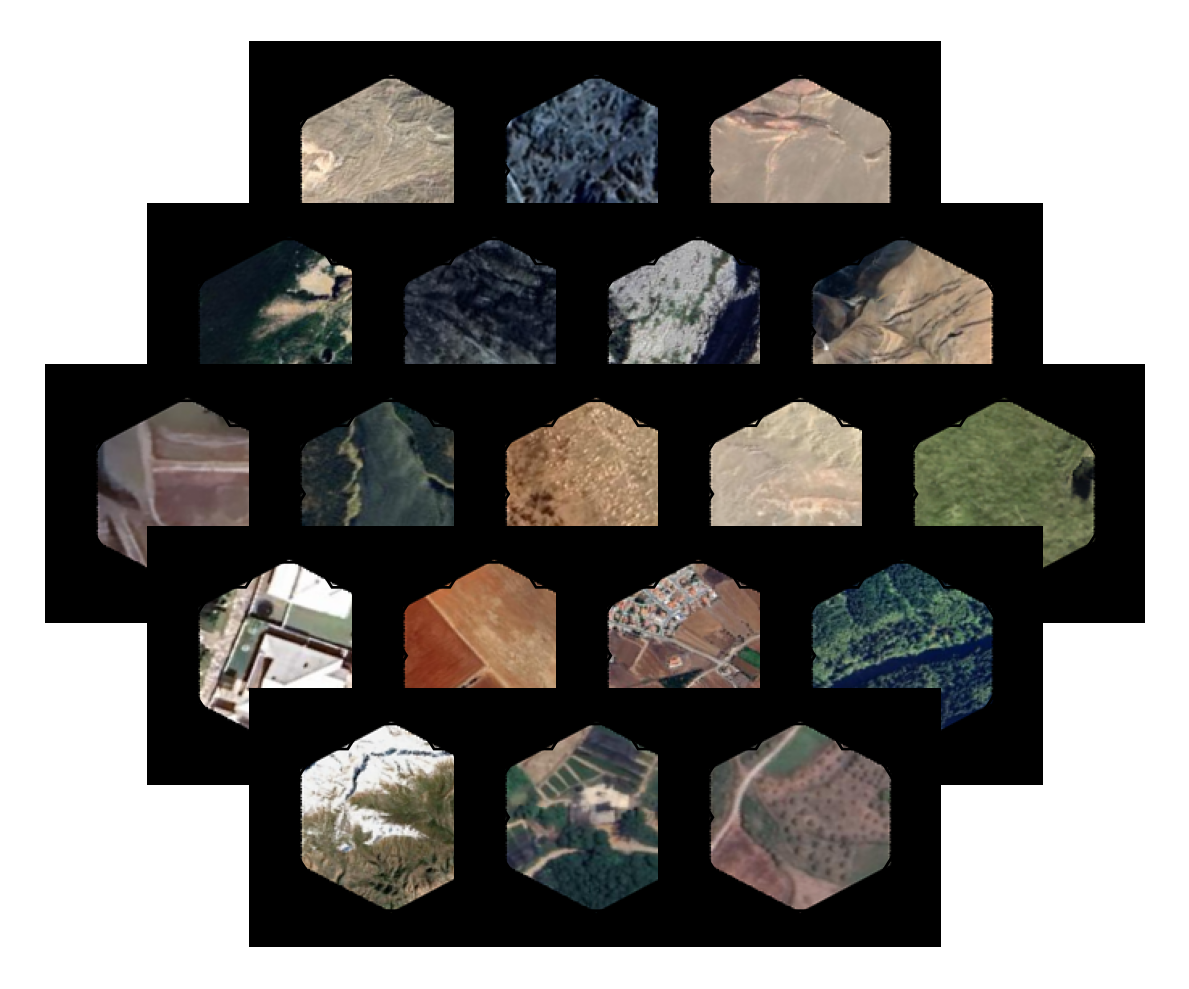

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import RegularPolygon
from matplotlib.patches import Polygon
from PIL import Image
import os
import random

def create_catan_board(image_dir='hex_dataset/images'):
    # Load 19 random images from the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) < 19:
        raise ValueError(f"Need at least 19 images, found {len(image_files)}")
    
    selected_images = random.sample(image_files, 19)
    images = [Image.open(os.path.join(image_dir, img)) for img in selected_images]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.set_aspect('equal')
    
    # Hex dimensions (pointy-top orientation)
    hex_size = 1.0
    
    # For pointy-top hexagons:
    # Width (flat-to-flat) = sqrt(3) * size
    # Height (point-to-point) = 2 * size
    width = np.sqrt(3) * hex_size
    height = 2 * hex_size
    
    # Vertical spacing between rows
    vert_spacing = 1.5 * hex_size
    # Horizontal spacing between columns
    horiz_spacing = width
    
    # Catan board layout: 3-4-5-4-3 rows
    rows = [3, 4, 5, 4, 3]
    
    # Starting y position (top of board)
    y_start = 0
    
    hexagons = []
    image_idx = 0
    
    for row_idx, num_hexes in enumerate(rows):
        y = y_start - row_idx * vert_spacing
        
        # Calculate x offset to center the row
        # The middle row (row 2 with 5 hexes) is our reference
        offset = (5 - num_hexes) * horiz_spacing / 2
        
        for col_idx in range(num_hexes):
            x = col_idx * horiz_spacing + offset
            
            # Get the image for this hex
            img = images[image_idx]
            
            # Crop the black borders from the 128px wide hex image
            # For a flat-top hex that's 128px wide, the height is 128 * 2/sqrt(3) ≈ 147.7px
            # But we only want the hex content, not the black padding
            # The actual hex inscribed in the image spans the full 128px width
            # Crop to just the hexagon shape (remove top/bottom black areas)
            img_width, img_height = img.size
            hex_height = int(img_width * 2 / np.sqrt(3))
            
            # Crop centered vertically to get just the hex content
            if img_height > hex_height:
                top_crop = (img_height - hex_height) // 2
                bottom_crop = top_crop + hex_height
                img = img.crop((0, top_crop, img_width, bottom_crop))
            
            # Rotate image 30 degrees (since it's generated flat-top but needs to be pointy-top)
            img_rotated = img.rotate(30, expand=True, resample=Image.BICUBIC)
            
            # Calculate hexagon vertices for pointy-top orientation
            angles = np.linspace(0, 2*np.pi, 7) + np.pi/6
            vertices = np.column_stack([
                x + hex_size * np.cos(angles),
                y + hex_size * np.sin(angles)
            ])
            
            # Display the image within the hex bounds
            extent = [
                x - hex_size * 1.2, x + hex_size * 1.2,
                y - hex_size * 1.2, y + hex_size * 1.2
            ]
            ax.imshow(img_rotated, extent=extent, aspect='auto', zorder=1)
            
            # Draw hexagon border on top
            hexagon = RegularPolygon(
                (x, y), 
                numVertices=6, 
                radius=hex_size,
                orientation=np.pi/6,
                facecolor='none',
                edgecolor='black',
                linewidth=2,
                zorder=2
            )
            ax.add_patch(hexagon)
            hexagons.append((x, y))
            image_idx += 1
    
    # Set axis limits with some padding
    all_x = [h[0] for h in hexagons]
    all_y = [h[1] for h in hexagons]
    
    padding = 1.5
    ax.set_xlim(min(all_x) - padding, max(all_x) + padding)
    ax.set_ylim(min(all_y) - padding, max(all_y) + padding)
    
    # Remove axes
    ax.axis('off')
    
    # White background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    plt.tight_layout()
    plt.show()

# Generate the board
create_catan_board()

In [3]:
import pickle
from pathlib import Path

# If running in Jupyter, __file__ is not defined
BASE_DIR = Path.cwd()

pkl_path = BASE_DIR / "data/sentinel_256_final.pkl"

with open(pkl_path, "rb") as f:
    data = pickle.load(f)

print(type(data))

if isinstance(data, list):
    print("Length:", len(data))
    print("First shape:", data[0].shape)

elif isinstance(data, dict):
    print("Keys:", list(data.keys())[:5])
    first = next(iter(data.values()))
    print("First shape:", first.shape)


<class 'dict'>
Keys: ['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial']
First shape: (3000, 256, 256, 3)


In [4]:
from pathlib import Path
import pickle
import numpy as np
import cv2

# -----------------------
# Paths (relative)
# -----------------------
BASE_DIR = Path(__file__).resolve().parent
PKL_PATH = BASE_DIR / "data/sentinel_256_final.pkl"
OUT_DIR = BASE_DIR / "unpickled_output"

OUT_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------
# Load pickle
# -----------------------
with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

print("Loaded type:", type(data))

# -----------------------
# Helpers
# -----------------------
def save_item(item, name):
    if isinstance(item, np.ndarray) and item.ndim in (2, 3):
        # Assume image
        if item.ndim == 3 and item.shape[2] == 3:
            item = cv2.cvtColor(item, cv2.COLOR_RGB2BGR)

        cv2.imwrite(str(OUT_DIR / f"{name}.png"), item)
    else:
        # Save anything else as pickle
        with open(OUT_DIR / f"{name}.pkl", "wb") as f:
            pickle.dump(item, f)

# -----------------------
# Save contents
# -----------------------
if isinstance(data, list):
    for i, item in enumerate(data):
        save_item(item, f"item_{i:06d}")

elif isinstance(data, dict):
    for key, item in data.items():
        safe_key = str(key).replace("/", "_")
        save_item(item, safe_key)

else:
    # Single object
    save_item(data, "data")

print(f"✅ Saved contents to: {OUT_DIR.resolve()}")


ModuleNotFoundError: No module named 'cv2'

In [2]:
import torch
import clip
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import pickle

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: False
Device count: 0


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
import torch
import clip
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import pickle

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from pathlib import Path
BASE_DIR = Path.cwd()

IMG_DIR = BASE_DIR / "hex_dataset/images"
OUT_PKL = BASE_DIR / "hex_embeddings.pkl"

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

embeddings = []
paths = []

for img_path in tqdm(sorted(IMG_DIR.glob("*.png"))):
    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        emb = model.encode_image(img_tensor).cpu().numpy()[0]

    embeddings.append(emb)
    paths.append(img_path.name)

with open(OUT_PKL, "wb") as f:
    pickle.dump({
        "embeddings": np.array(embeddings),
        "paths": paths
    }, f)

print("Saved embeddings:", OUT_PKL)


  1%|▏         | 511/39303 [00:35<44:41, 14.47it/s]


KeyboardInterrupt: 

In [4]:
import pickle
from pathlib import Path
import numpy as np

BASE_DIR = Path.cwd()
PKL = BASE_DIR / "hex_embeddings.pkl"

with open(PKL, "rb") as f:
    data = pickle.load(f)

print("Keys:", data.keys())
print("Embeddings type:", type(data["embeddings"]))
print("Embeddings shape:", np.array(data["embeddings"]).shape)
print("Number of paths:", len(data["paths"]))


Keys: dict_keys(['embeddings', 'paths'])
Embeddings type: <class 'numpy.ndarray'>
Embeddings shape: (0,)
Number of paths: 0


In [3]:
import pickle
import numpy as np
from sklearn.cluster import KMeans

from pathlib import Path
BASE_DIR = Path.cwd()

EMB_PKL = BASE_DIR / "hex_embeddings.pkl"

with open(EMB_PKL, "rb") as f:
    data = pickle.load(f)

X = data["embeddings"]

kmeans = KMeans(n_clusters=30, random_state=42)
labels = kmeans.fit_predict(X)

with open(BASE_DIR / "hex_clusters.pkl", "wb") as f:
    pickle.dump({
        "paths": data["paths"],
        "cluster_labels": labels
    }, f)

print("Saved cluster labels")


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.